In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pycircstat import mean as cmean, cdiff
from library.utils import load_pickle
import matplotlib as mpl

# ====================================== Global params and paths ==================================
legendsize = 8
load_dir = 'sim_results/fig6'
save_dir = 'plots/FigNWGtalk/'
os.makedirs(save_dir, exist_ok=True)
plt.rcParams.update({'font.size': legendsize,
                     "axes.titlesize": legendsize,
                     'axes.labelpad': 0,
                     'axes.titlepad': 0,
                     'xtick.major.pad': 0,
                     'ytick.major.pad': 0,
                     'lines.linewidth': 1,
                     'figure.figsize': (5.2, 5.5),
                     'figure.dpi': 300,
                     'axes.spines.top': False,
                     'axes.spines.right': False,
                     })

In [2]:
def get_neighbors(nid, dims):
    # Get neighboring 8 indices after unravelling to a 2D matrix according to dims,
    # clockwise starting from 12 o'clock

    rid, cid = np.unravel_index(nid, dims)

    # Check boundary conditions
    dim1, dim2 = dims
    ridmax, ridmin = rid+1, rid-1
    cidmax, cidmin = cid+1, cid-1

    if (ridmax > (dim1-1)) or (cidmax > (dim2-1)) or (ridmin < 0) or (cidmin < 0):
        return None, (rid, cid)
    else:
        nid1 = np.ravel_multi_index((ridmin, cid), dims)
        nid2 = np.ravel_multi_index((ridmin, cidmax), dims)
        nid3 = np.ravel_multi_index((rid, cidmax), dims)
        nid4 = np.ravel_multi_index((ridmax, cidmax), dims)
        nid5 = np.ravel_multi_index((ridmax, cid), dims)
        nid6 = np.ravel_multi_index((ridmax, cidmin), dims)
        nid7 = np.ravel_multi_index((rid, cidmin), dims)
        nid8 = np.ravel_multi_index((ridmin, cidmin), dims)
        neighbors = np.array([nid1, nid2, nid3, nid4, nid5, nid6, nid7, nid8])
        return neighbors, (rid, cid)


In [48]:
# 0, 90, 225

theta_ranges = [
    [5000, 6000],
    [15000, 16000],
    [75000, 76000],
    [165000, 166000]
]

# fig, ax = plt.subplots(2, 4, figsize=(12, 6))

vec_dict = dict()

for exin_i, exintag in enumerate(['in', 'ex']):

    if exintag == 'in':
        center_x, center_y = 0, 20
    elif exintag == 'ex':
        center_x, center_y = 0, -20
    else:
        raise ValueError

    simdata = load_pickle(join(load_dir, 'fig6_%s.pkl' % exintag))

    BehDF = simdata['BehDF']
    SpikeDF = simdata['SpikeDF']
    NeuronDF = simdata['NeuronDF']
    MetaData = simdata['MetaData']
    config_dict = simdata['Config']

    theta_phase_plot = BehDF['theta_phase_plot']
    traj_x = BehDF['traj_x'].to_numpy()
    traj_y = BehDF['traj_y'].to_numpy()
    traj_a = BehDF['traj_a'].to_numpy()
    t = BehDF['t'].to_numpy()
    theta_phase = BehDF['theta_phase'].to_numpy()

    nn_ca3 = MetaData['nn_ca3']

    xxtun1d = NeuronDF['neuronx'].to_numpy()
    yytun1d = NeuronDF['neurony'].to_numpy()
    aatun1d = NeuronDF['neurona'].to_numpy()

    xxtun1d_ca3 = xxtun1d[:nn_ca3]
    yytun1d_ca3 = yytun1d[:nn_ca3]
    aatun1d_ca3 = aatun1d[:nn_ca3]
    nx_ca3, ny_ca3 = config_dict['nx_ca3'], config_dict['ny_ca3']
    xxtun2d_ca3 = xxtun1d_ca3.reshape(nx_ca3, nx_ca3)  # Assuming nx = ny
    yytun2d_ca3 = yytun1d_ca3.reshape(nx_ca3, nx_ca3)  # Assuming nx = ny
    aatun2d_ca3 = aatun1d_ca3.reshape(nx_ca3, nx_ca3)  # Assuming nx = ny

    Ipos_max_compen = config_dict['Ipos_max_compen']
    Iangle_diff = config_dict['Iangle_diff']
    Iangle_kappa = config_dict['Iangle_kappa']
    xmin, xmax, ymin, ymax = config_dict['xmin'], config_dict['xmax'], config_dict['ymin'], config_dict['ymax']
    theta_f = config_dict['theta_f']  # in Hz
    theta_T = 1 / theta_f * 1e3  # in ms
    dt = config_dict['dt']
    traj_d = np.append(0, np.cumsum(np.sqrt(np.diff(traj_x) ** 2 + np.diff(traj_y) ** 2)))


    for rangei, (starti, endi) in enumerate(theta_ranges):


        animal_x = traj_x[starti:endi].mean()
        animal_y = traj_y[starti:endi].mean()


        SpikeDF['tsp'] = SpikeDF['tidxsp'].apply(lambda x: t[x])
        all_nidx = []
        spdftmplist = []
        for nid in range(nn_ca3):
            spdf_each = SpikeDF[(SpikeDF['neuronid'] == nid) & (SpikeDF['tidxsp'] > starti) & (SpikeDF['tidxsp'] <= endi)]
            num_sp = spdf_each.shape[0]
            if num_sp > 0:
                all_nidx.append(nid)
                spdftmplist.append(spdf_each)
        all_nidx = np.sort(np.array(all_nidx))
        SpikeDF_subset = pd.concat(spdftmplist, ignore_index=True)



        num_vecs = all_nidx.shape[0]
        vec_x = np.zeros(num_vecs)
        vec_y = np.zeros(num_vecs)
        vec_dx = np.zeros(num_vecs)
        vec_dy = np.zeros(num_vecs)
        valid_ind = []


        for i, nidx in enumerate(all_nidx):
            neighbors, (rid, cid) = get_neighbors(nidx, (nx_ca3, ny_ca3))
            centerx, centery = xxtun1d_ca3[nidx], yytun1d_ca3[nidx]

            spdf_MN = SpikeDF_subset[SpikeDF_subset['neuronid'] == nidx]
            tidxsp = spdf_MN['tidxsp'].to_numpy()
            if tidxsp.shape[0] > 1:
                phase_center = cmean(theta_phase[tidxsp])
            elif tidxsp.shape[0] == 1:
                phase_center = theta_phase[tidxsp]
            else:
                phase_center = None

            if (neighbors is not None):

                # Check if all the neighbors are inside the admitted population
                true_neighs = []
                for neiid in neighbors:
                    if neiid in all_nidx:
                        true_neighs.append(True)
                    else:
                        true_neighs.append(False)

                if np.sum(true_neighs) > 7:

                    neigh_x = xxtun1d_ca3[neighbors]
                    neigh_y = yytun1d_ca3[neighbors]

                    geo_vec = neigh_x - centerx + 1j * (neigh_y - centery)
                    geo_rad = np.angle(geo_vec)

                    phasediff = np.zeros(neighbors.shape[0])
                    for j, neiid in enumerate(neighbors):

                        spdf_MN = SpikeDF_subset[SpikeDF_subset['neuronid'] == neiid]
                        tidxsp = spdf_MN['tidxsp'].to_numpy()
                        if tidxsp.shape[0] > 1:
                            phase_neigh = cmean(theta_phase[tidxsp])
                        elif tidxsp.shape[0] == 1:
                            phase_neigh = theta_phase[tidxsp]
                        else:
                            phase_neigh = None

                        phasediff[j] = phase_neigh - phase_center

                    mean_vec = np.sum(phasediff * np.exp(1j * geo_rad))/phasediff.shape[0]
                    vec_x[i] = centerx
                    vec_y[i] = centery
                    vec_dx[i] = np.real(mean_vec)
                    vec_dy[i] = np.imag(mean_vec)
                    valid_ind.append(i)
                    # mean_angle = np.angle(mean_vec)
                    # mean_vec = np.exp(1j * mean_angle)
                    # mean_vec = mean_vec /5
                    # ax[exin_i, rangei].arrow(centerx, centery, np.real(mean_vec), np.imag(mean_vec), head_width=0.1,
                    #          color=arrow_cmap(arrow_cnorm(mean_angle)))
                    #
                    # ax[exin_i, rangei].scatter(animal_x, animal_y)
        vec_dict['x_%d_%d'%(exin_i, rangei)] = vec_x[valid_ind]
        vec_dict['y_%d_%d'%(exin_i, rangei)] = vec_y[valid_ind]
        vec_dict['dx_%d_%d'%(exin_i, rangei)] = vec_dx[valid_ind]
        vec_dict['dy_%d_%d'%(exin_i, rangei)] = vec_dy[valid_ind]
        vec_dict['animalx_%d_%d'%(exin_i, rangei)] = animal_x
        vec_dict['animaly_%d_%d'%(exin_i, rangei)] = animal_y


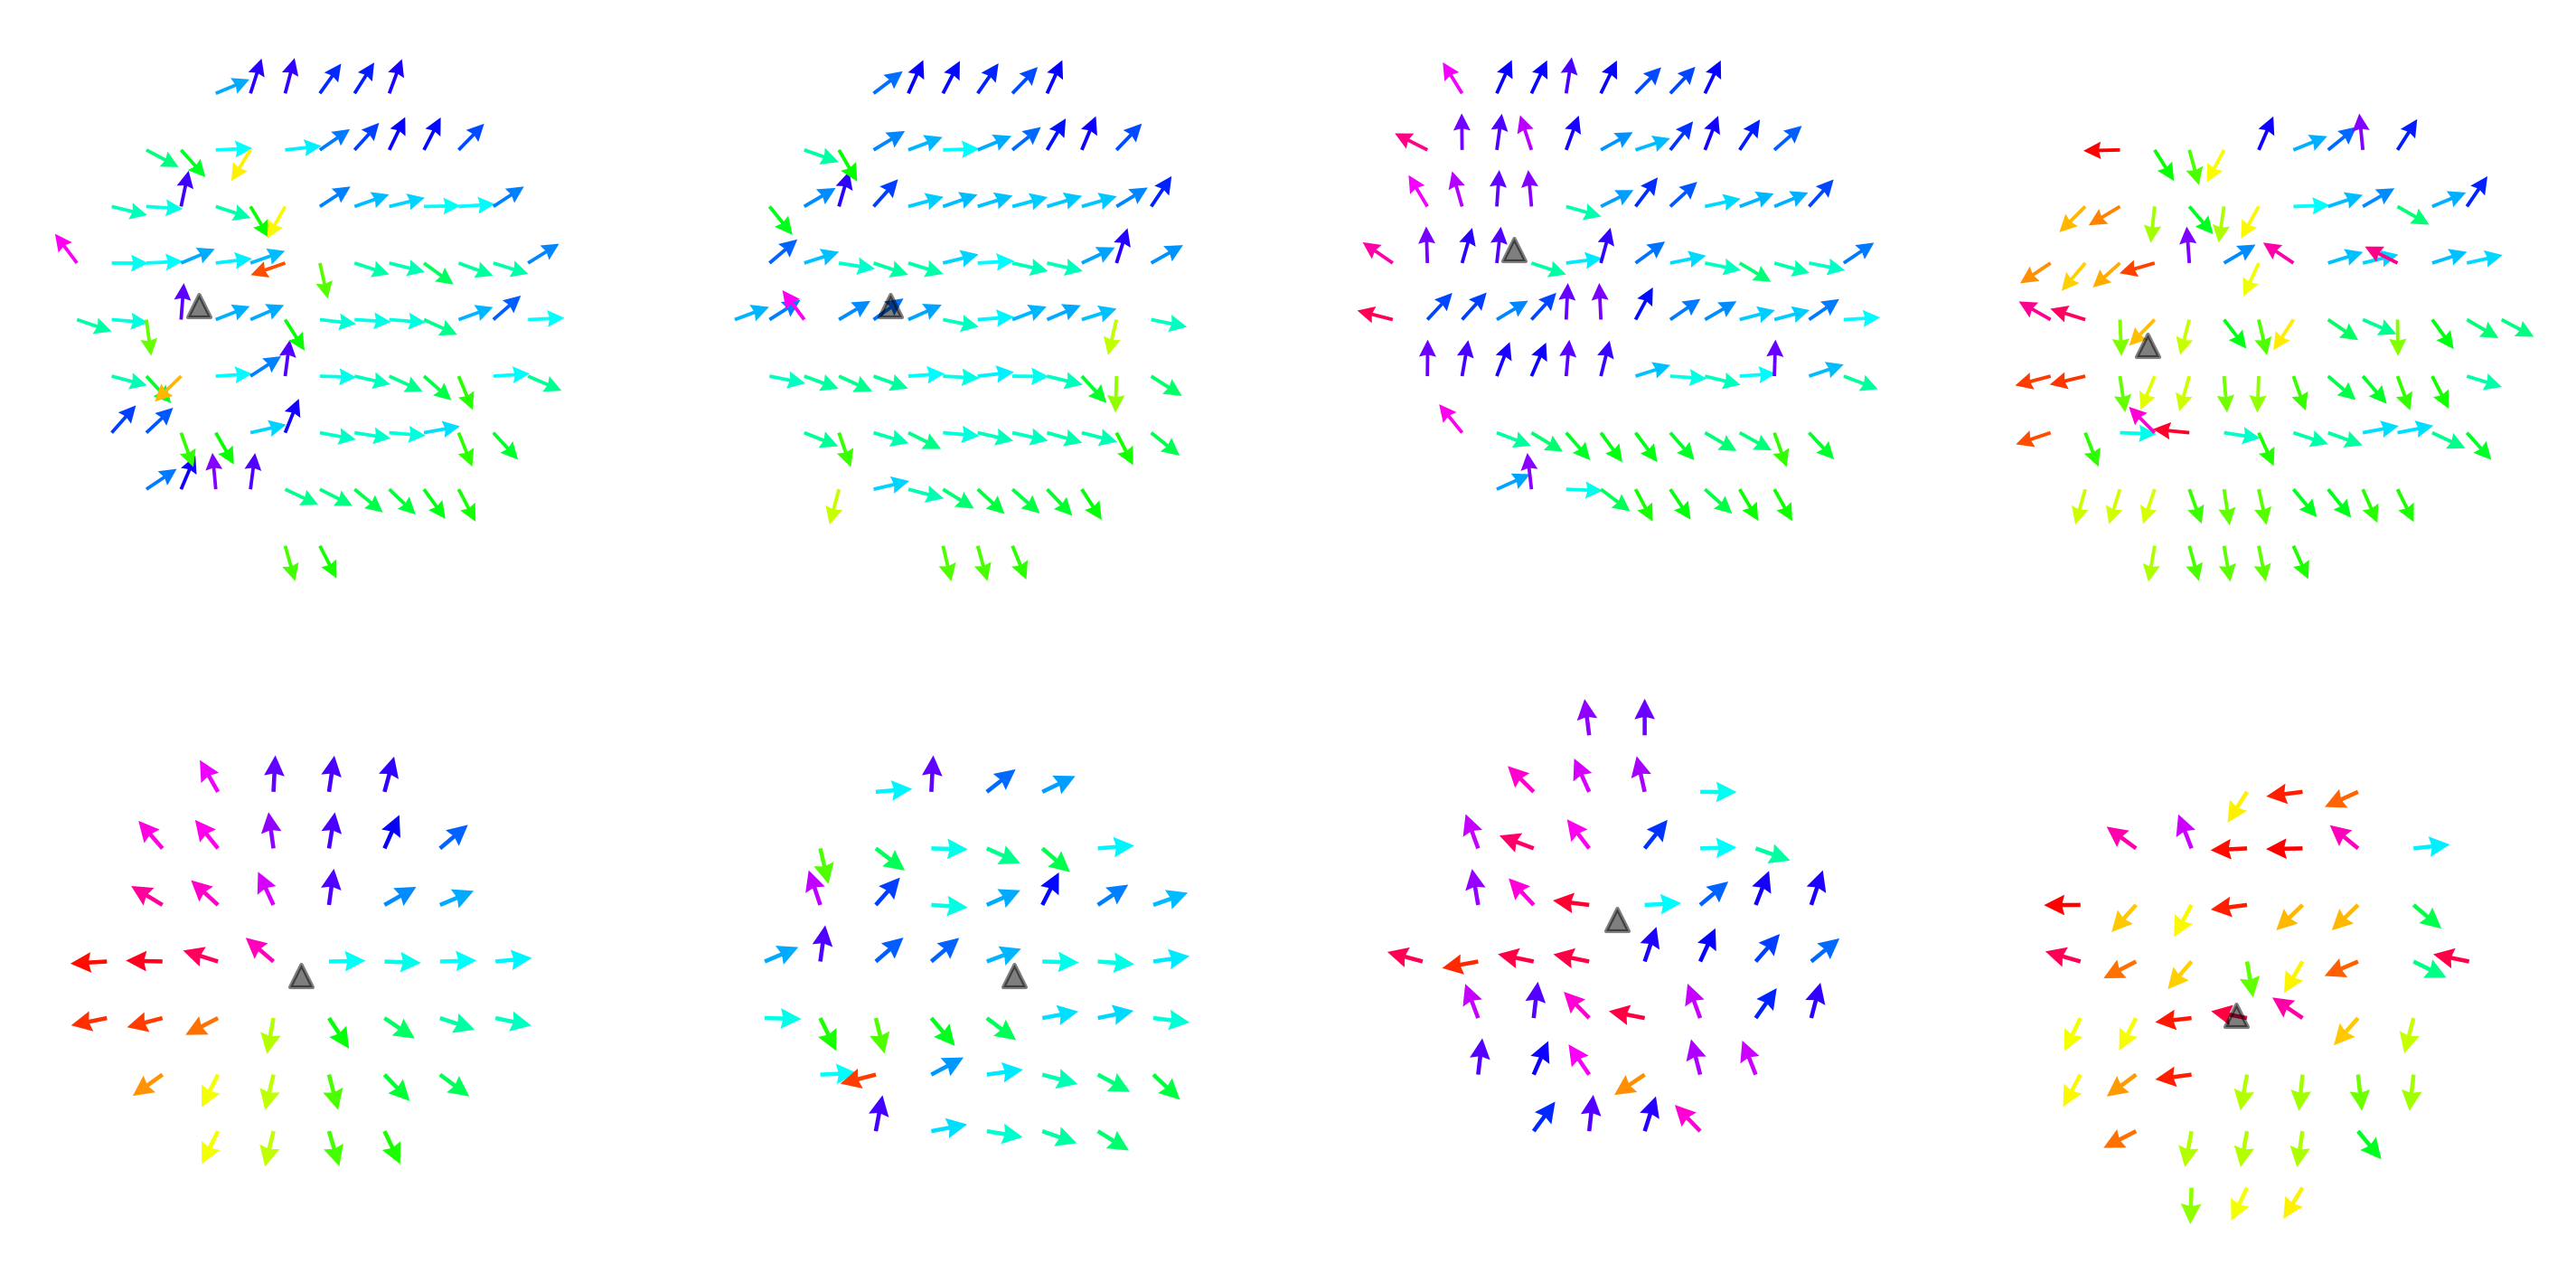

In [79]:
arrow_cnorm = mpl.colors.Normalize(vmin=-np.pi, vmax=np.pi)
arrow_cmap = plt.cm.get_cmap('hsv')

fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey='row', sharex='row')

for exin_i, exintag in enumerate(['in', 'ex']):
    for rangei, (starti, endi) in enumerate(theta_ranges):
        vec_x = vec_dict['x_%d_%d'%(exin_i, rangei)]
        vec_y = vec_dict['y_%d_%d'%(exin_i, rangei)]
        vec_dx = vec_dict['dx_%d_%d'%(exin_i, rangei)]
        vec_dy = vec_dict['dy_%d_%d'%(exin_i, rangei)]
        animal_x = vec_dict['animalx_%d_%d'%(exin_i, rangei)]
        animal_y = vec_dict['animaly_%d_%d'%(exin_i, rangei)]

        vec_angle = np.angle(vec_dx + 1j * vec_dy)
        norm_vec = np.exp(1j * vec_angle)


        ax[exin_i, rangei].quiver(vec_x, vec_y, np.real(norm_vec), np.imag(norm_vec),
                                  color=arrow_cmap(arrow_cnorm(vec_angle)), headwidth=5, scale=15
                                  )


        ax[exin_i, rangei].scatter(animal_x, animal_y, marker='^', c='k', alpha=0.5)

        if exin_i == 0:
            ax[exin_i, rangei].set_xlim(-5, 11)
            ax[exin_i, rangei].set_ylim(15, 25)
        else:
            ax[exin_i, rangei].set_xlim(-5, 5)
            ax[exin_i, rangei].set_ylim(-25, -15)
        ax[exin_i, rangei].axis('off')
fig.savefig(join(save_dir, 'Tempotron_arrows.png'), dpi=200)
fig.savefig(join(save_dir, 'Tempotron_arrows.svg'))